In [212]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from tqdm import tqdm

from helpers import vec

In [214]:
from Systems import LinearSystemModel

# Kinematic Car Example System
#  - state: {position, velocity}
#  - control: {acceleration}
#  - dynamics: f(x, u) = position + velocity*dt + (1/2)(acceleration + noise)*dt**2
#  - measurement: h(x) = position + noise

dt = 0.1
A = np.array([                  # dynamics model
    [1, dt],
    [0, 1]
])
B = np.array([                  # dynamics model
    [0.5 * dt**2],
    [dt]
])
C = np.array([                  # measurement model
    [1, 0]
])

accel_variance = 0.01           # process noise
R = B @ B.T * accel_variance

measurement_variance = 0.3      # measurement noise
Q = np.array([[measurement_variance]])

car_system_gt = LinearSystemModel(A, B, C, R, Q)


In [215]:
# Run the simulation

timesteps = np.arange(0.0, 15.0, step=dt)
T = len(timesteps)

states_gt = np.zeros((T, 2, 1))
controls = np.zeros((T, 1, 1))

# initial position and velocity
states_gt[0] = vec(0, 0)

measurements = np.zeros((T, 1, 1))

# acceleration schedule
controls[10:50] = vec(1.0)
controls[50:90] = vec(-1.0)

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = car_system_gt.dynamics_model(x, u)
    states_gt[t] = x_next

    z = car_system_gt.measurement_model(x)
    measurements[t] = z

100%|██████████| 149/149 [00:00<00:00, 5572.36it/s]


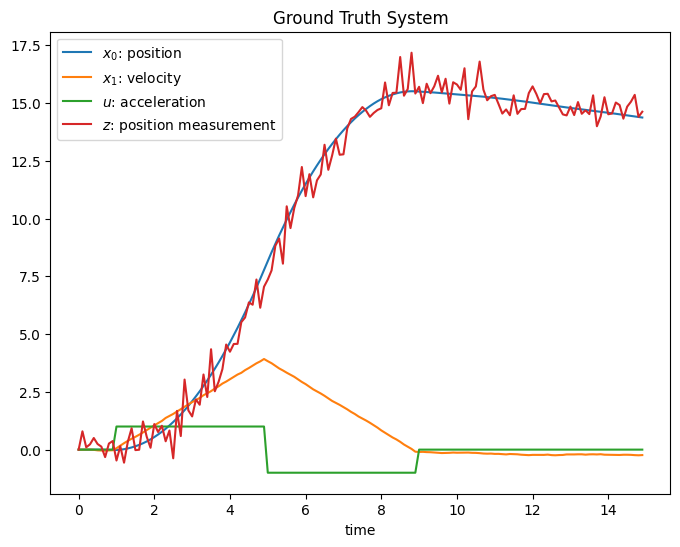

In [216]:
plt.figure(figsize=(8, 6))
plt.title("Ground Truth System")
plt.xlabel("time")
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.legend()

In [217]:
from Filters import KalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
car_system_approx = deepcopy(car_system_gt)

car_filter = KalmanFilter(car_system_approx)

In [218]:
# Run the filter

# initial state belief
car_filter.initialize(
    vec(np.random.normal(0, 1), np.random.normal(0, 1)),      # initial mean
    np.array([      # initial covariance
        [0.1, 0.0],
        [0.0, 0.1]
    ])
)

means = np.zeros((T, 2, 1))
covariances = np.zeros((T, 2, 2))

means[0] = car_filter.mean
covariances[0] = car_filter.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter.predict_step(u)
    car_filter.update_step(z)

    means[t] = car_filter.mean
    covariances[t] = car_filter.covariance

100%|██████████| 149/149 [00:00<00:00, 24860.82it/s]


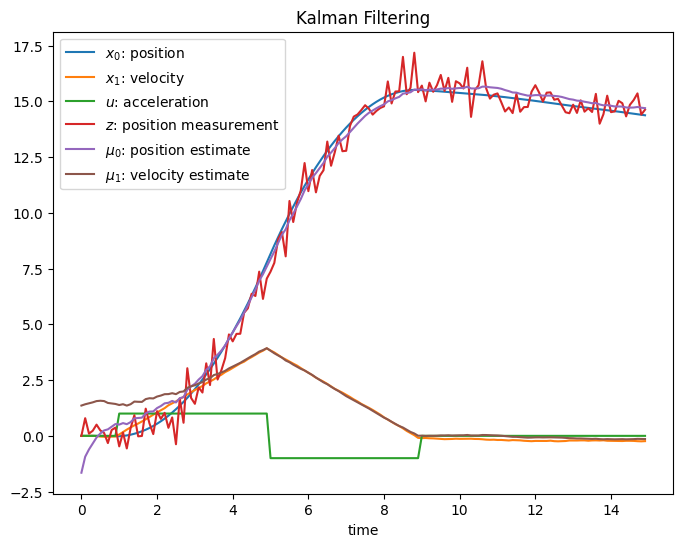

In [219]:
plt.figure(figsize=(8, 6))
plt.title("Kalman Filtering")
plt.xlabel("time")
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

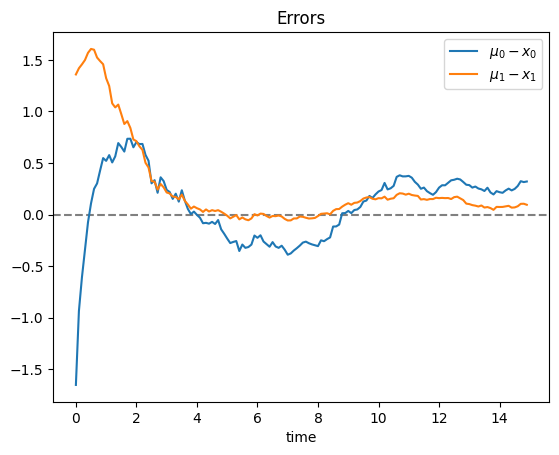

In [220]:
plt.title("Errors")
plt.xlabel("time")
plt.axhline(0, color="gray", linestyle="--")
plt.plot(timesteps, means[:,0] - states_gt[:,0], label="$\mu_0 - x_0$")
plt.plot(timesteps, means[:,1] - states_gt[:,1], label="$\mu_1 - x_1$")
plt.legend()

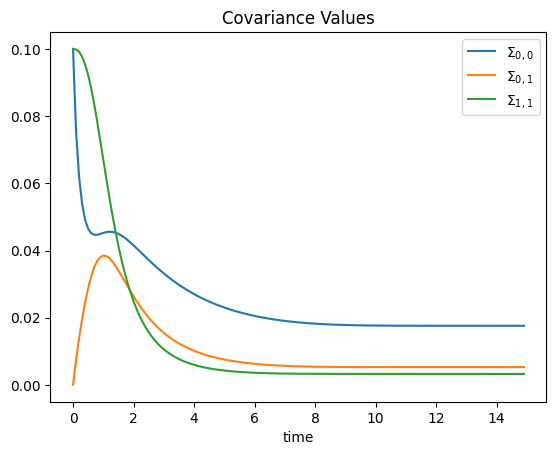

In [221]:
plt.title("Covariance Values")
plt.xlabel("time")
plt.plot(timesteps, covariances[:, 0, 0], label="$\Sigma_{0,0}$")
plt.plot(timesteps, covariances[:, 0, 1], label="$\Sigma_{0,1}$")
plt.plot(timesteps, covariances[:, 1, 1], label="$\Sigma_{1,1}$")
plt.legend()